In [1]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
import sys
import time
import numpy as np
from sklearn.model_selection import train_test_split,KFold
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,precision_score,confusion_matrix
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import cross_validate,cross_val_score
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import classification_report

In [2]:
# inspect the data
def Data_Inspection(data):
    Cov_type=data.iloc[:,-1]
    Wilderness_Area=pd.DataFrame(data.iloc[:,10:14].values.argmax(axis=1))
    Soil_type=pd.DataFrame(data.iloc[:,14:54].values.argmax(axis=1))
    Others=data.iloc[:,0:10]
    Raw_data=data.iloc[:,0:-1]
    count=list()
    
    # count the number for each cover type
    for ctype in range(1,8):
        index=np.array(Cov_type.index[Cov_type==ctype])
        count.append(len(index))
    count=np.array(count)   


    plt.bar(np.arange(1,8), height= count)
    plt.xlabel('Labels',fontsize=15)
    plt.ylabel('Count',fontsize=15)
    plt.xticks(rotation=90)
    plt.show()
    for i in range(0,7):
        print('Type:',i+1,count[i])
    print('Total:',data.shape[0])

In [3]:
def Preprocessing_data(data,n_columns,n_range,normalized_check):
    # Preprocessing
    Cov_type=data.iloc[:,-1]
    Raw_data=data.iloc[:,0:-1]
    # one hot encoding 
    labels = pd.get_dummies(Cov_type)
    
    # Rescale
    # Normalization
    Normalized_data=Raw_data
    if(normalized_check):
        min_max_scaler = MinMaxScaler(feature_range=n_range, copy=True)
        Normalized_data = min_max_scaler.fit_transform(data)

    # PCA
    pca = PCA(n_components=n_columns, copy=True)
    if(normalized_check):
        PCA_data = pca.fit_transform(Normalized_data)
    else:
        PCA_data = pca.fit_transform(Raw_data)
    
    # Calculate the explained variance ratio
    print("Explained variance ratio:", round(pca.explained_variance_ratio_.sum(),4))
    
    return PCA_data, labels, pca.explained_variance_ratio_.sum()

In [37]:
def plot_confusion_matrix(confusion_matrix,title):
    cm = confusion_matrix.astype('float') / confusion_matrix.sum(axis=0)
    #cm=confusion_matrix
    df_cm = pd.DataFrame(cm,np.arange(1,8),columns=np.arange(1,8))
    
    plt.figure(figsize = (15,9))
    plt.title( title) 
    #sn.heatmap(df_cm, annot=True, fmt="d")
    sn.heatmap(df_cm, annot=True)

In [25]:
# KNN
def KNN_Classifier_K_FOLD(X,Y,k,k_fold):
    # Classifier: KNN
    knn= KNeighborsClassifier(n_neighbors=k)
    
    # K-fold cross validation
    # cv: Number of folds, n_jobs:The number of CPUs to use to do the computation. -1 means ‘all CPUs’.
    kf = KFold(n_splits=k_fold, random_state=42,shuffle=True)
    scores = cross_val_score(knn, X, Y, n_jobs=-1, cv=kf)
    #scores = cross_validate(knn, X, Y, n_jobs=-1, cv=kf)
    
    print("Accuracy score:",round(scores.mean(),4))
    return scores.mean()

# Analyze KNN classifier with different dimension reduction
def KNN_PCA_Dimension_Analysis(data,dimension_range,k,k_fold,nc):
    timeList=list()
    accuracyList=list()
    varianceList=list()
    
    for r in dimension_range:
        Start=time.time()
        
        # propressing data with normalization and pca
        n_range=(0,1)
        normalized_check=nc;
        PCA_data, labels,variance=Preprocessing_data(data,r,n_range,normalized_check)
        
        # K-fold cross validatation
        scores=KNN_Classifier_K_FOLD(PCA_data,labels,k,k_fold)
        End = time.time()
        running_time = End - Start
        print("Running time: ",round(running_time,4))
        
        # add the results to the lists
        timeList.append(running_time)
        accuracyList.append(scores)
        varianceList.append(variance)
        
    
    return timeList,accuracyList,varianceList

# Analyze KNN classifier with different nearest number
def KNN_K_Analysis(data,n_columns,k_range,k_fold,nc):
    timeList=list()
    accuracyList=list()
    for k in k_range:
        Start=time.time()
        
        # propressing data with normalization and pca
        n_range=(0,1)
        normalized_check=nc;
        PCA_data, labels,variance=Preprocessing_data(data,n_columns,n_range,normalized_check)
        
        # K-fold cross validatation
        scores=KNN_Classifier_K_FOLD(PCA_data,labels,k,k_fold)
        End = time.time()
        running_time = End - Start
        print("Running time: ",round(running_time,4))
        
        # add the results to the lists
        timeList.append(running_time)
        accuracyList.append(scores)
        
    # plot the result diagram 
    plt.plot(k_range,accuracyList)
    plt.title( 'Nearest number VS Accuracy (KNN)') 
    plt.xlabel('Nearest number K')
    plt.ylabel('Accuracy')
    plt.show()
    
    plt.plot(k_range,timeList)
    plt.title( 'Nearest number VS Running time (KNN)') 
    plt.xlabel('Nearest number K')
    plt.ylabel('Running time')
    plt.show()


# Analyze KNN classifier with confusion matrix
def KNN_Classifier_Analysis(data,n_columns,k,ratio,nc):
    Start=time.time()
    
    # propressing data with normalization and pca
    n_range=(0,1)
    normalized_check=nc;
    PCA_data, labels,variance=Preprocessing_data(data,n_columns,n_range,normalized_check)
    
    # define the knn classifier
    knn= KNeighborsClassifier(n_neighbors=k)

    # split the data
    X_train, X_test, y_train, y_test = train_test_split(PCA_data, labels, test_size=ratio, random_state=42)
    
    # train the model
    knn.fit(X_train,y_train)
    
    # predict the classes
    prediction=knn.predict(X_test)
    score = accuracy_score(y_test, prediction)
    print("Accuracy score:",score)
    End = time.time()
    running_time = End - Start
    print("Running time: ",round(running_time,4))
    
    # generate confusion matrix
    cm = confusion_matrix(y_test.values.argmax(axis=1), prediction.argmax(axis=1))
    plot_confusion_matrix(cm,'KNN Confusion Matrix')
    
    # generate classification report
    print (classification_report(y_test.values.argmax(axis=1), prediction.argmax(axis=1)))

In [31]:
# Random forest classifer
def RF_Classifier_K_FOLD(X,Y,nTree,k_fold):
    # Classifier: Random forest
    rf= RandomForestClassifier(n_estimators=nTree)
    
    # K-fold cross validation
    # cv: Number of folds, n_jobs:The number of CPUs to use to do the computation. -1 means ‘all CPUs’.
    kf = KFold(n_splits=k_fold, random_state=42,shuffle=True)
    scores = cross_val_score(rf, X, Y, n_jobs=-1, cv=kf)
    print("Accuracy score:",round(scores.mean(),4))
    return scores.mean()

# Analyze RF classifier with different dimension reduction
def RF_PCA_Dimension_Analysis(data,dimension_range,nTree,k_fold,nc):
    timeList=list()
    accuracyList=list()
    varianceList=list()
    for r in dimension_range:
        Start=time.time()
        
        # propressing data only with pca
        n_range=(0,1)
        normalized_check=nc;
        PCA_data, labels,variance=Preprocessing_data(data,r,n_range,normalized_check)
        
        # K-fold cross validatation
        scores=RF_Classifier_K_FOLD(PCA_data,labels,nTree,k_fold)
        End = time.time()
        running_time = End - Start
        print("Running time: ",round(running_time,4))
        
        # add the results to the lists
        timeList.append(running_time)
        accuracyList.append(scores)
        varianceList.append(variance)
    
    
    return timeList,accuracyList,varianceList
    

# Analyze RF classifier with different tree numbers
def RF_nTree_Analysis(data,n_columns,nTree_range,k_fold,nc):
    timeList=list()
    accuracyList=list()
    for t in nTree_range:
        Start=time.time()
        
        #propressing data only with pca
        n_range=(0,1)
        normalized_check=nc;
        PCA_data, labels,variance=Preprocessing_data(data,n_columns,n_range,normalized_check)
        
        # K-fold cross validatation
        scores=RF_Classifier_K_FOLD(PCA_data,labels,t,k_fold)
        End = time.time()
        running_time = End - Start
        print("Running time: ",round(running_time,4))
        
        # add the results to the lists
        timeList.append(running_time)
        accuracyList.append(scores)
    
    # plot the result diagram
    plt.plot(nTree_range,accuracyList)
    plt.title( 'Number of Trees VS Accuracy (RF)') 
    plt.xlabel('Number of Trees')
    plt.ylabel('Accuracy')
    plt.show()
    
    plt.plot(nTree_range,timeList)
    plt.title( 'Number of Trees VS Running time (RF)') 
    plt.xlabel('Number of Trees')
    plt.ylabel('Running time')
    plt.show()


# Analyze RF classifier with confusion matrix
def RF_Classifier_Analysis(data,n_columns,nTree,ratio,nc):
    Start=time.time()
    
    # propressing data only with pca
    n_range=(0,100)
    normalized_check=nc;
    PCA_data, labels,variance=Preprocessing_data(data,n_columns,n_range,normalized_check)
    
    # define the random forest classidfier
    rf= RandomForestClassifier(n_estimators=nTree)

    # SPlit the data
    X_train, X_test, y_train, y_test = train_test_split(PCA_data, labels, test_size=ratio, random_state=42)
    
    # train the model
    rf.fit(X_train,y_train)
    
    # predict the classes
    prediction=rf.predict(X_test)
    score = accuracy_score(y_test, prediction)
    print("Accuracy score:",score)
    End = time.time()
    running_time = End - Start
    print("Running time: ",round(running_time,4))
    
    # generate the confusion matrix
    cm = confusion_matrix(y_test.values.argmax(axis=1), prediction.argmax(axis=1))
    plot_confusion_matrix(cm,'RF Confusion Matrix')
    
    # generate the classification report
    print (classification_report(y_test.values.argmax(axis=1), prediction.argmax(axis=1)))

In [7]:
# Logistic regression classifer

# Analyze LR classifier with different dimension reduction
def LR_Normalization_Analysis(data,n_columns,normalized_range,nc):
    timeList=list()
    accuracyList=list()
    varianceList=list()
    for n in normalized_range:
        Start=time.time()
    
        # propressing data only with pca and normalization, range 0 to 1
        n_range=(0,n)
        normalized_check=nc;
        PCA_data, labels,variance=Preprocessing_data(data,n_columns,n_range,normalized_check)
    
        # define the logistic regression 
        lr=LogisticRegression(multi_class='multinomial',solver ='saga',max_iter=100,random_state=42,n_jobs=-1)
    
        # split the data
        X_train, X_test, y_train, y_test = train_test_split(PCA_data, data.iloc[:,-1], test_size=0.1, random_state=42)
    
        # train the model
        lr.fit(X_train,y_train)
    
        # predict the results
        prediction=lr.predict(X_test)
        scores = accuracy_score(y_test, prediction)
        print("Prediction:",scores)
        End = time.time()
        running_time = End - Start
        print("Running time: ",round(running_time,4))
        timeList.append(running_time)
        accuracyList.append(scores)
        varianceList.append(variance)
        
    plt.plot(normalized_range,accuracyList)
    plt.title( 'Normalized range VS Accuracy (LR)') 
    plt.xlabel('Range')
    plt.ylabel('Accuracy')
    plt.show()
    
    plt.plot(normalized_range,timeList)
    plt.title( 'Normalized range VS Running Time (LR)') 
    plt.xlabel('Range')
    plt.ylabel('Running time')
    plt.show()
    
    
# Analyze LR classifier with different normalization rage
def LR_PCA_Dimension_Analysis(data,dimension_range,nc):
    timeList=list()
    accuracyList=list()
    varianceList=list()
    for r in dimension_range:
        Start=time.time()
    
        # propressing data only with pca and normalization, range 0 to 1
        n_range=(0,1)
        normalized_check=nc;
        PCA_data, labels,variance=Preprocessing_data(data,r,n_range,normalized_check)
    
        # define the logistic regression 
        lr=LogisticRegression(multi_class='multinomial',solver ='saga',max_iter=100,random_state=42,n_jobs=-1)
    
        # split the data
        X_train, X_test, y_train, y_test = train_test_split(PCA_data, data.iloc[:,-1], test_size=0.1, random_state=42)
    
        # train the model
        lr.fit(X_train,y_train)
    
        # predict the results
        prediction=lr.predict(X_test)
        scores = accuracy_score(y_test, prediction)
        print("Prediction:",scores)
        End = time.time()
        running_time = End - Start
        print("Running time: ",round(running_time,4))
        timeList.append(running_time)
        accuracyList.append(scores)
        varianceList.append(variance)
        
    
    return timeList,accuracyList,varianceList
    


# Analyze LR classifier with confusion matrix
def LR_Classifier_Analysis(data,n_columns,ratio,nc):
    Start=time.time()
    
    # propressing data only with pca and normalization, range 0 to 1
    n_range=(0,1)
    normalized_check=nc;
    PCA_data, labels,variance=Preprocessing_data(data,n_columns,n_range,normalized_check)
    
    # define the logistic regression 
    lr=LogisticRegression(multi_class='multinomial',solver ='saga',max_iter=100,random_state=42,n_jobs=-1)
    
    
    # split the data
    X_train, X_test, y_train, y_test = train_test_split(PCA_data, data.iloc[:,-1], test_size=ratio, random_state=42)
    
    # train the model
    lr.fit(X_train,y_train)
    
    # predict the results
    prediction=lr.predict(X_test)
    score = accuracy_score(y_test, prediction)
    print("Accuracy score:",score)
    End = time.time()
    running_time = End - Start
    print("Running time: ",round(running_time,4))
    
    # generate the confusion matrix
    cm = confusion_matrix(y_test, prediction)
    plot_confusion_matrix(cm,'LR Confusion Matrix')
    
    # generate the classification report
    print (classification_report(y_test, prediction))

In [8]:
def Adjust_data_amount(data):
    index=np.array(data.index[data.iloc[:,-1]==1])
    sdata=data.iloc[index,:].sample(2500)

    #pd.concat([s1, s2], ignore_index=True)
    for ctype in range(2,8):
            if ctype == 4:
                index=np.array(data.index[data.iloc[:,-1]==ctype])
                temp=data.iloc[index,:].sample(2500)
                sdata=pd.concat([sdata, temp], ignore_index=True)
            elif ctype ==5:
                index=np.array(data.index[data.iloc[:,-1]==ctype])
                temp=data.iloc[index,:].sample(2500)
                sdata=pd.concat([sdata, temp], ignore_index=True)
            elif ctype ==6:
                index=np.array(data.index[data.iloc[:,-1]==ctype])
                temp=data.iloc[index,:].sample(2500)
                sdata=pd.concat([sdata, temp], ignore_index=True)
            else:
                index=np.array(data.index[data.iloc[:,-1]==ctype])
                temp=data.iloc[index,:].sample(2500)
                sdata=pd.concat([sdata, temp], ignore_index=True)

    sdata.sample(frac=1).reset_index(drop=True)
    return sdata

In [9]:
# Read the data
data = pd.read_csv("covtype.data",header=None, index_col=False)
# Names of the features
names=['Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology','Horizontal_Distance_To_Roadways','Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points','Wilderness_Area','Soil_Type','Cover_Type']
data.head()

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


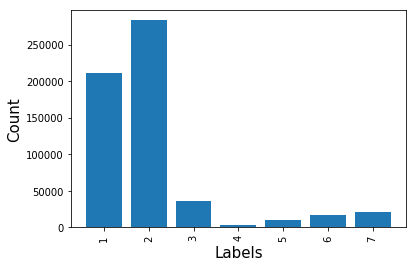

Type: 1 211840
Type: 2 283301
Type: 3 35754
Type: 4 2747
Type: 5 9493
Type: 6 17367
Type: 7 20510
Total: 581012


In [10]:

Data_Inspection(data)


In [11]:
# PCA dimension analysis
PCA_range=np.arange(2,11)
KNN_k=15
Tree_number=5
k_fold=10
normalized_check=True;
KNN_time,KNN_accuracy,KNN_v =KNN_PCA_Dimension_Analysis(data,PCA_range,KNN_k,k_fold,normalized_check)
RF_time,RF_accuracy,RF_v=RF_PCA_Dimension_Analysis(data,PCA_range,Tree_number,k_fold,normalized_check)
LR_time,LR_accuracy,LR_v=LR_PCA_Dimension_Analysis(data,PCA_range,normalized_check)

Explained variance ratio: 0.3758
Accuracy score: 0.7422
Running time:  9.7384
Explained variance ratio: 0.4442
Accuracy score: 0.9047
Running time:  11.2215
Explained variance ratio: 0.5058
Accuracy score: 0.9608
Running time:  12.7123
Explained variance ratio: 0.5541
Accuracy score: 0.9845
Running time:  13.8465
Explained variance ratio: 0.6003
Accuracy score: 0.9884
Running time:  14.4488
Explained variance ratio: 0.6411
Accuracy score: 0.9962
Running time:  15.8051
Explained variance ratio: 0.6744
Accuracy score: 0.9963
Running time:  16.3958
Explained variance ratio: 0.7038
Accuracy score: 0.9981
Running time:  18.4014
Explained variance ratio: 0.7323
Accuracy score: 0.9997
Running time:  18.6996
Explained variance ratio: 0.3758
Accuracy score: 0.7171
Running time:  47.1305
Explained variance ratio: 0.4442
Accuracy score: 0.893
Running time:  42.9716
Explained variance ratio: 0.5058
Accuracy score: 0.9691
Running time:  57.1349
Explained variance ratio: 0.5541
Accuracy score: 0.984

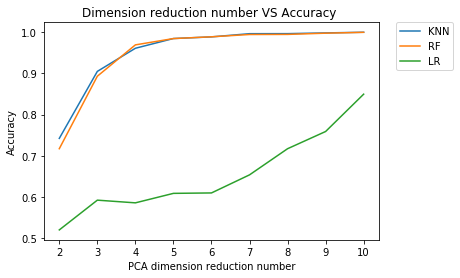

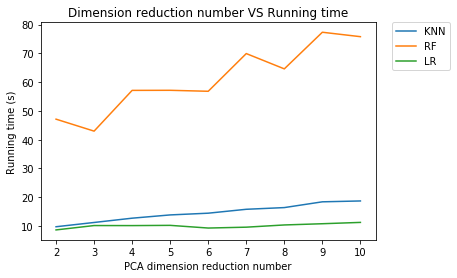

No handles with labels found to put in legend.


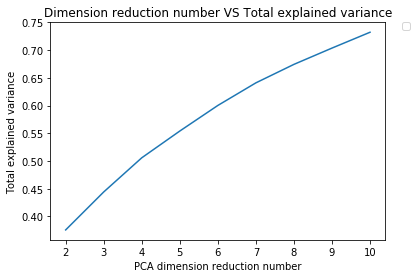

In [12]:
PCA_range=np.arange(2,11)
# PCA dimension analysis plot
plt.plot(PCA_range,KNN_accuracy,label='KNN')
plt.plot(PCA_range,RF_accuracy,label='RF')
plt.plot(PCA_range,LR_accuracy,label='LR')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title( 'Dimension reduction number VS Accuracy ') 
plt.xlabel('PCA dimension reduction number')
plt.ylabel('Accuracy')
plt.show()

plt.plot(PCA_range,KNN_time,label='KNN')
plt.plot(PCA_range,RF_time,label='RF')
plt.plot(PCA_range,LR_time,label='LR')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title( 'Dimension reduction number VS Running time') 
plt.xlabel('PCA dimension reduction number')
plt.ylabel('Running time (s)')
plt.show()


plt.plot(PCA_range,KNN_v)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title( 'Dimension reduction number VS Total explained variance') 
plt.xlabel('PCA dimension reduction number')
plt.ylabel('Total explained variance')
plt.show()



Explained variance ratio: 0.5541
Accuracy score: 0.9918
Running time:  10.4326
Explained variance ratio: 0.5541
Accuracy score: 0.9862
Running time:  13.7827
Explained variance ratio: 0.5541
Accuracy score: 0.9822
Running time:  13.7063
Explained variance ratio: 0.5541
Accuracy score: 0.9792
Running time:  16.1742
Explained variance ratio: 0.5541
Accuracy score: 0.9764
Running time:  16.8898
Explained variance ratio: 0.5541
Accuracy score: 0.974
Running time:  20.2995
Explained variance ratio: 0.5541
Accuracy score: 0.9717
Running time:  23.4543
Explained variance ratio: 0.5541
Accuracy score: 0.9696
Running time:  26.6754
Explained variance ratio: 0.5541
Accuracy score: 0.9672
Running time:  26.5137
Explained variance ratio: 0.5541
Accuracy score: 0.965
Running time:  27.767
Explained variance ratio: 0.5541
Accuracy score: 0.9629
Running time:  31.0958


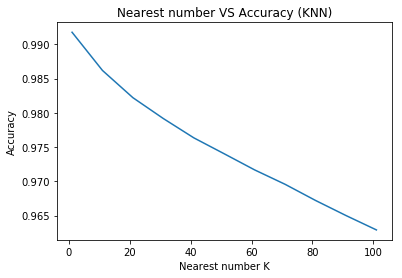

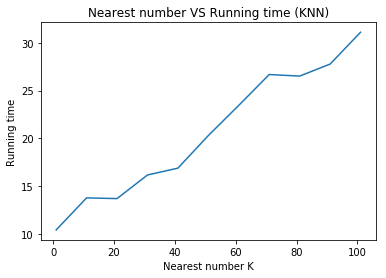

In [13]:
# KNN Classifier analysis
# Test with different K
n_columns=5
k_range=np.arange(1,111,10)
k_fold=10
normalized_check=True
KNN_K_Analysis(data,n_columns,k_range,k_fold,normalized_check)


Explained variance ratio: 0.5541
Accuracy score: 0.9900647576429078
Running time:  7.259
             precision    recall  f1-score   support

          1       0.99      0.99      0.99     84633
          2       0.99      0.99      0.99    113390
          3       0.97      0.98      0.98     14269
          4       0.82      0.75      0.78      1065
          5       0.99      0.98      0.99      3906
          6       1.00      1.00      1.00      6995
          7       0.99      1.00      0.99      8147

avg / total       0.99      0.99      0.99    232405



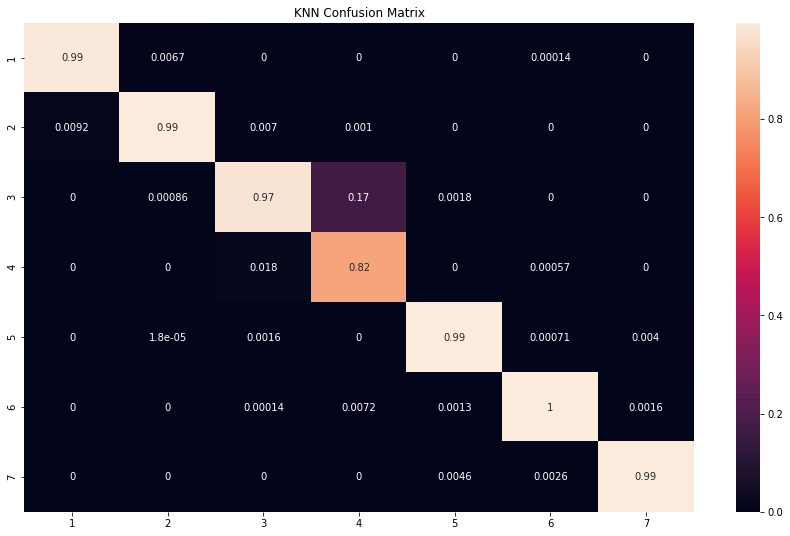

In [41]:
# KNN Classifier analysis
# Classfication report
n_columns=5
optimal_k=1
test_ratio=0.4
normalized_check=True
KNN_Classifier_Analysis(data,n_columns,optimal_k,test_ratio,normalized_check)

Explained variance ratio: 0.5541
Accuracy score: 0.9653
Running time:  18.9127
Explained variance ratio: 0.5541
Accuracy score: 0.9788
Running time:  75.0636
Explained variance ratio: 0.5541
Accuracy score: 0.9873
Running time:  125.3762
Explained variance ratio: 0.5541
Accuracy score: 0.9862
Running time:  172.6038


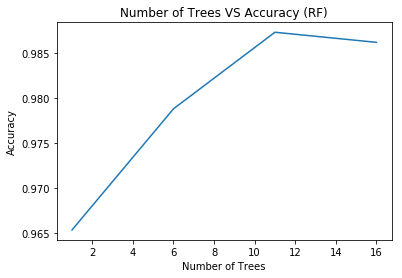

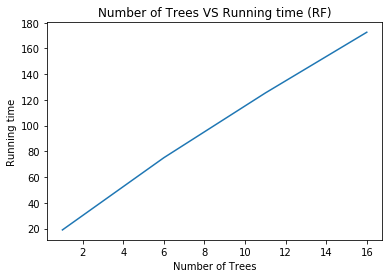

In [15]:
# RF Classifier analysis
# Test with different Tree number
n_columns=5
tree_range=np.arange(1,20,5)
k_fold=10
normalized_check=True
RF_nTree_Analysis(data,n_columns,tree_range,k_fold,normalized_check)


Explained variance ratio: 0.5541
Accuracy score: 0.9802672059551214
Running time:  26.0366
             precision    recall  f1-score   support

          0       0.97      0.99      0.98     84633
          1       0.99      0.98      0.99    113390
          2       0.97      0.97      0.97     14269
          3       0.89      0.63      0.74      1065
          4       0.99      0.95      0.97      3906
          5       0.99      0.99      0.99      6995
          6       0.99      0.99      0.99      8147

avg / total       0.98      0.98      0.98    232405



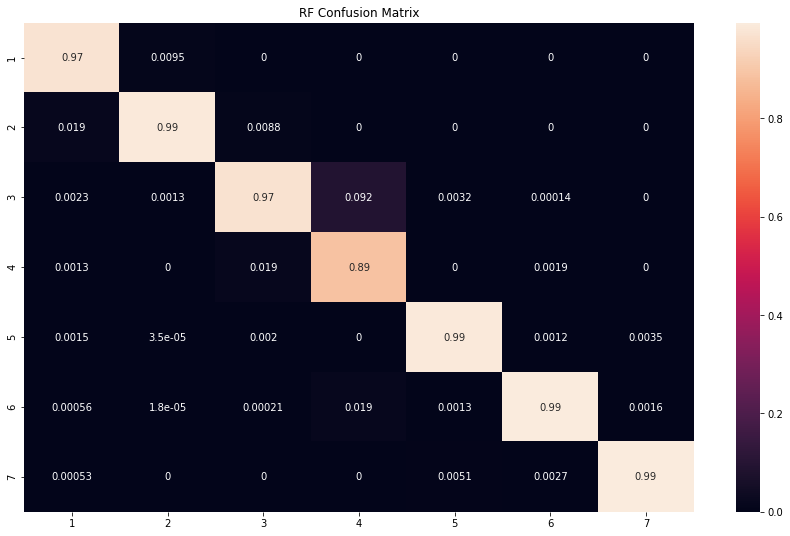

In [40]:
# RF Classifier analysis
# Classfication report
n_columns=5
optimal_tree_number=10
test_ratio=0.4
normalized_check=True
RF_Classifier_Analysis(data,n_columns,optimal_tree_number,test_ratio,normalized_check)

Explained variance ratio: 0.9987
Accuracy score: 0.45485714285714285
Running time:  0.3794
             precision    recall  f1-score   support

          1       0.23      0.06      0.09      1002
          2       0.60      0.21      0.32       994
          3       0.44      0.42      0.43       997
          4       0.44      0.83      0.57      1020
          5       0.77      0.45      0.57       965
          6       0.45      0.22      0.29      1029
          7       0.40      1.00      0.57       993

avg / total       0.48      0.45      0.41      7000



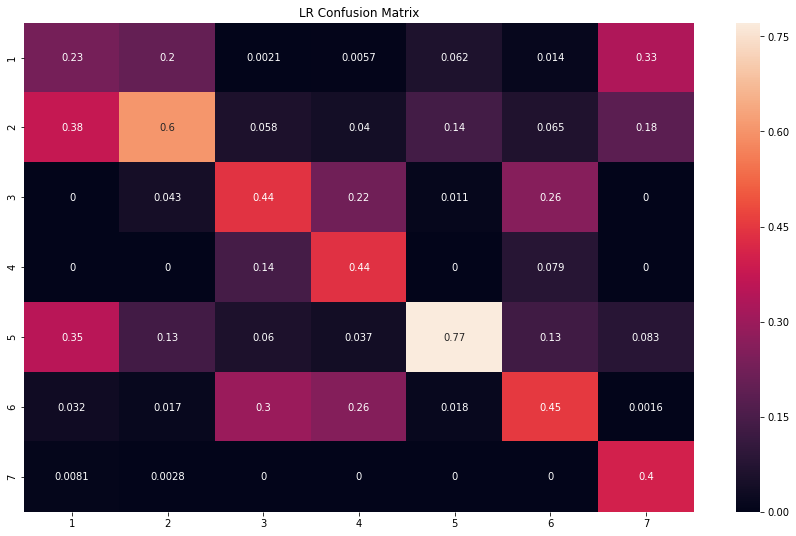

In [39]:
# LR Classifier analysis
# Change amount of samples
sdata=Adjust_data_amount(data)
n_columns=5
test_ratio=0.4
normalized_check=False
LR_Classifier_Analysis(sdata,n_columns,test_ratio,normalized_check)

Explained variance ratio: 0.7323
Prediction: 0.8523286633850814
Running time:  10.6219
Explained variance ratio: 0.7323


/Users/shengyuan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Prediction: 0.854393996764311
Running time:  51.1775
Explained variance ratio: 0.7323
Prediction: 0.8555471412343809
Running time:  51.1147
Explained variance ratio: 0.7323
Prediction: 0.8544284189872982
Running time:  51.6008
Explained variance ratio: 0.7323
Prediction: 0.8513992633644281
Running time:  54.1944
Explained variance ratio: 0.7323
Prediction: 0.8525007745000173
Running time:  52.4525
Explained variance ratio: 0.7323
Prediction: 0.8514508966989088
Running time:  52.0397
Explained variance ratio: 0.7323
Prediction: 0.855874152352759
Running time:  51.7196
Explained variance ratio: 0.7323
Prediction: 0.8449278854428419
Running time:  54.8865
Explained variance ratio: 0.7323
Prediction: 0.8489380744208461
Running time:  53.3063
Explained variance ratio: 0.7323
Prediction: 0.8419331520429589
Running time:  53.8474


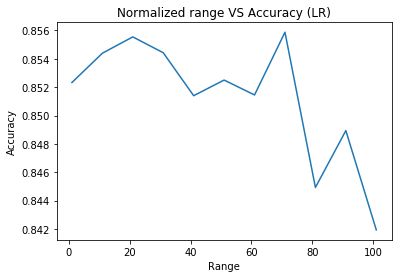

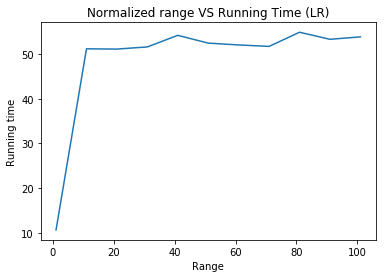

In [18]:
# LR Classifier analysis
n_columns=10
n_range=np.arange(1,110,10)
normalized_check=True
LR_Normalization_Analysis(data,n_columns,n_range,normalized_check)


Explained variance ratio: 0.7323
Accuracy score: 0.8476366687463694
Running time:  9.1847
             precision    recall  f1-score   support

          1       0.82      0.77      0.79     84633
          2       0.83      0.87      0.85    113390
          3       0.95      0.99      0.97     14269
          4       1.00      0.28      0.43      1065
          5       0.97      0.94      0.95      3906
          6       0.98      0.98      0.98      6995
          7       0.97      0.99      0.98      8147

avg / total       0.85      0.85      0.85    232405



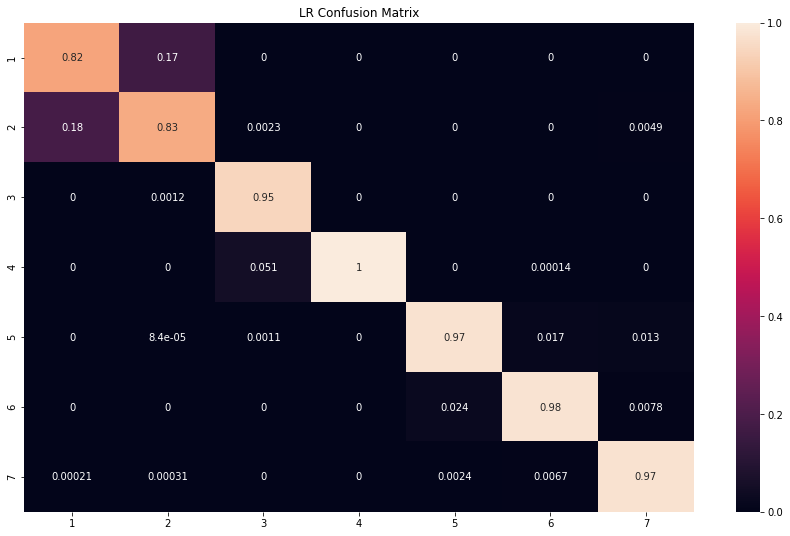

In [38]:
# LR Classifier analysis
# Classfication report
n_columns=10
test_ratio=0.4
normalized_check=True
LR_Classifier_Analysis(data,n_columns,test_ratio,normalized_check)